In [7]:
!pip install -q imageio
!pip install -q streamlit
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs
!pip3 install -q git+https://github.com/ultralytics/ultralytics.git

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [8]:
# Import Libraries

from matplotlib.collections import LineCollection
from IPython.display import HTML, display
from tensorflow_docs.vis import embed
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow_hub as hub
import tensorflow as tf
import streamlit as st
import pandas as pd
import ultralytics
import numpy as np
import imageio
import glob
import cv2
import os

yolo_model = ultralytics.YOLO(model='yolov8m-pose.pt')

# Mount drive to load video footages
drive.mount('/content/drive', force_remount=True)

# Dictionary to map joints of body part
KEYPOINT_DICT = {
    'nose':0,
    'left_eye':1,
    'right_eye':2,
    'left_ear':3,
    'right_ear':4,
    'left_shoulder':5,
    'right_shoulder':6,
    'left_elbow':7,
    'right_elbow':8,
    'left_wrist':9,
    'right_wrist':10,
    'left_hip':11,
    'right_hip':12,
    'left_knee':13,
    'right_knee':14,
    'left_ankle':15,
    'right_ankle':16
}
# map bones to matplotlib color name
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0,1): 'm',
    (0,2): 'c',
    (1,3): 'm',
    (2,4): 'c',
    (0,5): 'm',
    (0,6): 'c',
    (5,7): 'm',
    (7,9): 'm',
    (6,8): 'c',
    (8,10): 'c',
    (5,6): 'y',
    (5,11): 'm',
    (6,12): 'c',
    (11,12): 'y',
    (11,13): 'm',
    (13,15): 'm',
    (12,14): 'c',
    (14,16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_score,height,
                                     width,keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges"""
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances,_,_,_ = keypoints_with_score.shape
  for id in range(num_instances):
    kpts_x = keypoints_with_score[0,id,:,1]
    kpts_y = keypoints_with_score[0,id,:,0]
    kpts_scores = keypoints_with_score[0,id,:,2]
    kpts_abs_xy = np.stack(
        [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
    kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
    keypoints_all.append(kpts_above_thrs_abs)

    for edge_pair,color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_abs_xy[edge_pair[0],0]
        y_start = kpts_abs_xy[edge_pair[0],1]
        x_end = kpts_abs_xy[edge_pair[1],0]
        y_end = kpts_abs_xy[edge_pair[1],1]
        lien_seg = np.array([[x_start,y_start],[x_end,y_end]])
        keypoint_edges_all.append(lien_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all,axis=0)
  else:
    keypoints_xy = np.zeros((0,17,2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all,axis=0)
  else:
    edges_xy = np.zeros((0,2,2))
  return keypoints_xy,edges_xy,edge_colors

def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image"""
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

Mounted at /content/drive


## Load MoveNet Pose Estimation Model from Tensorflow Hub

In [9]:
model_name = "movenet_thunder"  #["movenet_lightning", "movenet_thunder", "movenet_lightning.tflite", "movenet_thunder.tflite"]

if "tflite" in model_name:
  if "movenet_lightning" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3?lite-format=tflite
    input_size = 192
  elif "movenet_thunder" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image"""
    # TF Lite format expects tensor type of float32.
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/3")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/3")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image"""
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoint_with_scores = outputs['output_0'].numpy()
    return keypoint_with_scores

## Initialise MoveNet For Video Sequence Processing

In [10]:
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region"""
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints"""
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location"""
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on"""
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region"""
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

# Training Pipeline

## Read and Slice frames and Preprocess data for Training Videos

In [11]:
# Assuming the text file is named "filename.txt"
# This file contain the frame number fall was detected on the videos
filename = "/content/drive/MyDrive/FallText.txt"

# Dictionary to store the train video names and numbers
video_label_text = {}

# Read the file line by line
with open(filename, 'r') as file:
    for line in file:
        # Remove leading and trailing whitespaces and split the line by ':'
        parts = line.strip().split(':')

        # Check if the line is in the format "test_video_name : number"
        if len(parts) == 2:
            # Extract the test_video_name and number
            video_name = parts[0].strip()
            number = int(parts[1].strip())

            # Add the data to the dictionary
            video_label_text[video_name] = number

In [12]:
count = 0
data_list = []

# Loading videos for training our system
directory = glob.glob('/content/drive/MyDrive/Artificial_Intelligence_Research_Development_Project/Train')

# Create an empty list and load video path
video_list = []
for dir in directory:
  for f in glob.glob(dir+'/*.avi'):
    video_list.append(f)

for i in range(0, len(video_list)):

  video_data = video_list[i]
  video_name = os.path.splitext(os.path.basename(video_data))[0]
  video = cv2.VideoCapture(video_data)
  success = True
  count = count + 1

  # print(count,test_video_name)
  f_count = 1
  fallen_frame = 0
  is_fall = False

  if video_name in video_label_text:
    fallen_frame = int(video_label_text[video_name])
    is_fall = True
  else:
    fallen_frame = 0
    is_fall = False

  while video.isOpened():
    success, image = video.read()

    if not success:
      break


    image_height, image_width, _ = image.shape
    crop_region = init_crop_region(image_height, image_width)

    input_image = crop_and_resize(tf.expand_dims(image, axis=0), crop_region= init_crop_region(720, 480), crop_size=[input_size, input_size])

    keypoints_with_scores = movenet(input_image)

    filename_frame_number = f"{video_name}_{f_count}"

    if is_fall:
      if f_count <= fallen_frame:
        label = 0
      else :
        label = 1
    if not is_fall:
      label = 0

    f_count = f_count +1

    data_list.append([filename_frame_number, keypoints_with_scores[0][0][:, 1:].flatten(),label])

  #if is_fall:
    #print(f'{count} Name:{video_name}, FallenPointFrame:{fallen_frame}, ALL Frames : {f_count}, FallFramesCount = {f_count - fallen_frame+1}, NonFallCount :{fallen_frame-1}')
  #else:
    #print(f'{count} Name:{video_name}, FallenPointFrame:{fallen_frame}, ALL Frames : {f_count}, FallFramesCount = {fallen_frame}, NonFallCount :{f_count}')

# Read keypoints and label into a dataframe
df = pd.DataFrame(data_list, columns=["Frame number", "Keypoints",'Class'])

# Save the dataFrame to csv for easy model training
csv_file_name = "Dataset.csv"
df.to_csv(csv_file_name, index=False)


## Model Training

In [13]:
df = pd.read_csv('/content/Dataset.csv')

# Convert the string representation of arrays to actual NumPy arrays
df['Keypoints'] = df['Keypoints'].apply(lambda x: np.array(x.strip('[]').split(), dtype=np.float32))

# Train data Initialisation
X = np.vstack(df['Keypoints'].values)
y = df['Class'].values

#SVM
from sklearn.svm import SVC
svm_clf = SVC(probability=True)
svm_clf.fit(X, y)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm_clf.score(X, y)))

Accuracy of SVM classifier on training set: 0.89


# Inference Pipeline

## Read and Slice frames for Test Videos

In [30]:
test_video = cv2.VideoCapture('/content/drive/MyDrive/Artificial_Intelligence_Research_Development_Project/Test/FallRightS6.avi')

output = []

while test_video.isOpened():
  success, image = test_video.read()
  if not success:
    break

  image_height, image_width, _ = image.shape
  crop_region = init_crop_region(image_height, image_width)

  test_input_image = crop_and_resize(tf.expand_dims(image, axis=0), crop_region, crop_size=[input_size, input_size])

  keypoints_with_scores = movenet(test_input_image)

  key_points = keypoints_with_scores[0][0][:, 1:].flatten()
  key_points = np.expand_dims(key_points, axis=0)
  result = svm_clf.predict_proba(key_points)[0][1]

  yolo_result = yolo_model.predict(image, save=False, verbose = False)[0]
  box_coords = yolo_result.boxes.xyxy.cpu()
  box_coords = box_coords.numpy()
  box_coords = box_coords.astype(int)

  if len(box_coords) > 0:
    # Extract the coordinates
    x_min, y_min, x_max, y_max = box_coords[0]

    # Draw the bounding box on the image
    color = (0, 0, 255) if result > 0.7 else (0, 255, 0)
    thickness = 2       # Line thickness
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

  # Draw the result on the frame
  text = "Fall" if result > 0.7 else "No Fall"
  cv2.putText(image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

  # Add the frame to the output video
  output.append(image)

# Release the video capture object
test_video.release()

# Write the output video with the predicted labels drawn on the frames
output_video_path = 'output_video.mp4'
output_height, output_width, _ = output[0].shape
output_video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'MP4V'), 30, (output_width, output_height))

for frame in output:
    output_video.write(frame)

# Release the output video object
output_video.release()

In [31]:
# Show output of Inference
from moviepy.editor import *

path="/content/output_video.mp4"

clip=VideoFileClip(path)
clip.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Inference Output Using Streamlit

In [32]:
%%writefile app.py
import streamlit as st
import os

def file_selector(folder_path=''):
    filenames = os.listdir(folder_path)
    selected_filename = st.sidebar.selectbox('Select a video file', filenames)
    return os.path.join(folder_path, selected_filename)

st.title('Fall Detection from Video footages')
video_file = open('/content/__temp__.mp4', 'rb')
video_bytes = video_file.read()
st.video(video_bytes)

video_file_buffer = st.sidebar.file_uploader('Upload a video', type = ["avi", "mp4"])

filename = file_selector("/content")
if st.button("Play video"):
        video_file = open(filename, 'rb')
        video_bytes = video_file.read()
        st.video(video_bytes)

Writing app.py


In [33]:
!npm install localtunnel
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.297s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities

34.147.64.68
npx: installed 22 in 3.836s
your url is: https://short-snakes-help.loca.lt


## Model Performance Evaluation

In [23]:
df_test = pd.read_csv('/content/drive/MyDrive/Artificial_Intelligence_Research_Development_Project/Test_Dataset_Final.csv')
df_test['Keypoints'] = df_test['Keypoints'].apply(lambda x: np.array(x.strip('[]').split(), dtype=np.float32))
X_test = np.vstack(df_test['Keypoints'].values)
y_test = df_test['Class'].values

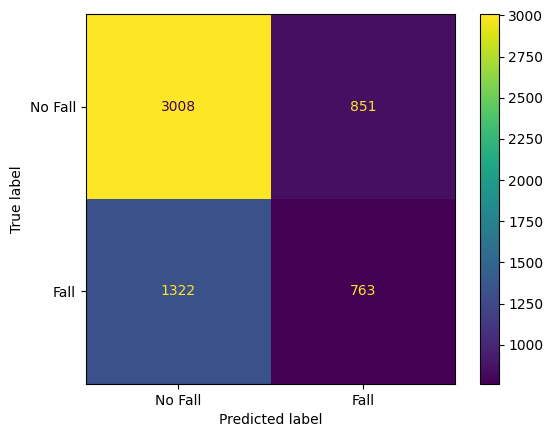

In [24]:
# SVM
from sklearn import metrics
pre = svm_clf.predict_proba(X_test)[:,1]
pred = np.rint(pre)

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Fall', 'Fall'])

cm_display.plot()
plt.show()

In [25]:
# Print Accuracy, Precision, F1_score and Recall
cm = confusion_matrix
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy: {:.3f}'.format(accuracy))
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print('Precision: {:.3f}'.format(precision))
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print('Recall: {:.3f}'.format(recall))
f1_score = 2 * (precision * recall) / (precision + recall)
print('F1 score: {:.3f}'.format(f1_score))

Accuracy: 0.634
Precision: 0.473
Recall: 0.366
F1 score: 0.413


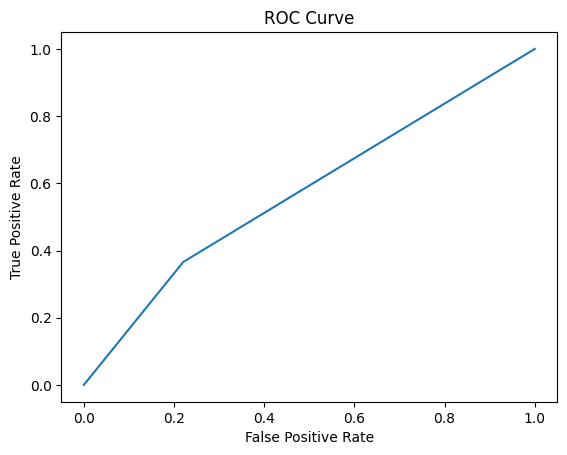

In [26]:
# Display ROC Curve
from sklearn.metrics import  roc_curve,auc

fpr, tpr, _ = roc_curve(y_test, pred)

plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()